In [4]:
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [5]:
df = pd.read_csv("M0405.csv")
df["time_"] = df.mon*100000 + df.day*1000 + df.mins
df = df.drop(["year","mon","day","mins"], axis=1)
df.tail()

,s_stat,e_stat,clock,number,speed,time_
1246747,05F0528N,05F0438N,327,6,99,909287.0
1246748,05F0309S,05F0439S,483,14,97,909287.0
1246749,05FR113S,05F0439S,109,4,105,909287.0
1246750,05F0439S,05F0494S,209,6,95,909287.0
1246751,05F0438N,05FR143N,104,5,107,909287.0


In [6]:
loc = pd.read_csv("location_clean.csv")

con = pd.DataFrame(loc.num1.str.split("-",2).tolist(), columns = ['highway','a'])
loc = pd.concat([loc, con.highway], axis=1)
loc = loc.drop(["num1"], axis=1)

print (loc.dir.value_counts())
print (con.highway.value_counts())
loc.tail()

N    166
S    165
Name: dir, dtype: int64
03F    152
01F    146
01H     15
05F     14
03A      4
Name: highway, dtype: int64


,dir,lat,lon,num2,highway
326,N,24.842639,121.789286,05F0287N,05F
327,N,24.823706,121.786214,05F0309N,05F
328,N,24.733917,121.782350,05FR143N,05F
329,N,24.710922,121.789597,05F0438N,05F
330,N,24.632717,121.807167,05F0528N,05F


In [7]:
loc.columns = ['dir', 'lat', 'lon', 's_stat', 'highway']
df_ = pd.merge(df, loc, how='left', on=['s_stat'])
loc.columns = ['dir', 'lat', 'lon', 'e_stat', 'highway']
df_ = pd.merge(df_, loc, how='left', on=['e_stat'])

df_.tail()

,s_stat,e_stat,clock,number,speed,time_,dir_x,lat_x,lon_x,highway_x,dir_y,lat_y,lon_y,highway_y
1246747,05F0528N,05F0438N,327,6,99,909287.0,N,24.632717,121.807167,05F,N,24.710922,121.789597,05F
1246748,05F0309S,05F0439S,483,14,97,909287.0,S,24.823706,121.786214,05F,S,24.711028,121.789478,05F
1246749,05FR113S,05F0439S,109,4,105,909287.0,S,24.733944,121.781989,05F,S,24.711028,121.789478,05F
1246750,05F0439S,05F0494S,209,6,95,909287.0,S,24.711028,121.789478,05F,S,24.662581,121.799850,05F
1246751,05F0438N,05FR143N,104,5,107,909287.0,N,24.710922,121.789597,05F,N,24.733917,121.782350,05F


### 處理南下路段

In [8]:
df_s = df_[(df_.dir_x == "S")].reset_index(drop=True)
print ("size of dataset at south direction :", df.shape[0])

size of dataset at south direction : 1246752


#### 站點組合和連接特性

In [9]:
f = {'lat_x':['mean'],'lon_x':['mean'],'lat_y':['mean'],'lon_y':['mean']}
g = df_s.groupby(["s_stat","e_stat"]).aggregate(f).reset_index()
g.columns = ["s_stat","e_stat","s_lat","s_lon","e_lat","e_lon"]

g_ = g.groupby(["s_stat"])["e_stat"].aggregate("count").reset_index()
g = pd.merge(g[["s_stat","e_stat"]], g_, on=['s_stat'], how='inner')
g.columns = ["s_stat","e_stat","inter"]

loc.columns = ['dir', 'lat', 'lon', 's_stat', 'highway']
g = pd.merge(g, loc, how='left', on=['s_stat'])
loc.columns = ['dir', 'lat', 'lon', 'e_stat', 'highway']
g = pd.merge(g, loc, how='left', on=['e_stat'])

g.tail(10)

,s_stat,e_stat,inter,dir_x,lat_x,lon_x,highway_x,dir_y,lat_y,lon_y,highway_y
230,03F4142S,01F3696N,2,S,22.579586,120.526161,03F,N,22.609428,120.339608,01F
231,03F4142S,03F4168S,2,S,22.579586,120.526161,03F,S,22.557186,120.524558,03F
232,03F4168S,03F4232S,1,S,22.557186,120.524558,03F,S,22.501367,120.525775,03F
233,03F4232S,03F4263S,1,S,22.501367,120.525775,03F,S,22.474661,120.530844,03F
234,05F0000S,05F0055S,1,S,25.035089,121.622931,05F,S,24.996467,121.652058,05F
235,05F0055S,05F0287S,1,S,24.996467,121.652058,05F,S,24.842569,121.788967,05F
236,05F0287S,05F0309S,1,S,24.842569,121.788967,05F,S,24.823706,121.786214,05F
237,05F0309S,05F0439S,1,S,24.823706,121.786214,05F,S,24.711028,121.789478,05F
238,05F0439S,05F0494S,1,S,24.711028,121.789478,05F,S,24.662581,121.799850,05F
239,05FR113S,05F0439S,1,S,24.733944,121.781989,05F,S,24.711028,121.789478,05F


In [32]:
direction = "S"
stat = "03F4142S"
mon = 9
day = 8
hr = 12
mins = 40
t = mon*100000 + day*1000 + (hr*60 + mins)/5

df = df_[(df_.dir_x == direction)&(df_.time_ < t)].reset_index(drop=True)
e_ = g[(g.s_stat == stat)].e_stat
s_ = g[(g.e_stat == stat)].s_stat
print (e_)
print (s_)

df1 = df[(df.s_stat == s_.iloc[0])]#[["clock","number","speed"]].reset_index(drop=True)
df2 = df[(df.s_stat == stat)]#[["clock","number","speed"]].reset_index(drop=True)
df3 = df[(df.s_stat == e_.iloc[0])]#[["clock","number","speed"]].reset_index(drop=True)
print (df1.shape, df2.shape, df3.shape)

230    01F3696N
231    03F4168S
Name: e_stat, dtype: object
229    03F4018S
Name: s_stat, dtype: object
(2168, 14) (4336, 14) (0, 14)


### 同道同道預測

In [33]:
def select_data(direction,stat,mon,day,hr,mins):
    t = mon*100000 + day*1000 + (hr*60 + mins)/5
############################################################################################################# need adjust
    df = df_[(df_.dir_x == direction)&(df_.time_ < t)].reset_index(drop=True)
    next_stat = g[(g.s_stat == stat)].e_stat
    last_stat = g[(g.e_stat == stat)].s_stat

    df1 = df[(df.s_stat == last_stat.iloc[0])][["clock","number","speed"]].reset_index(drop=True)
    df2 = df[(df.s_stat == stat)][["clock","number","speed"]].reset_index(drop=True)
    df3 = df[(df.s_stat == next_stat.iloc[0])][["clock","number","speed"]].reset_index(drop=True)
#############################################################################################################
    df = pd.concat([df1, df2, df3], axis=1).reset_index(drop=True)
    df.columns = ["last_c","last_n","last_s","_c","_n","_s","next_c","next_n","next_s"]
    df["speed"] = df._s
    # shift row for last step
    X = df.iloc[:-1,:9]
    y = df.iloc[1:,9].reset_index(drop=True)
    sc = StandardScaler(copy=True, with_mean=True, with_std=True)
    X = sc.fit_transform(X)
    test = df.iloc[[-1],:9]
    test = sc.transform(test)
    true = df_[(df_.s_stat == stat)&(df_.dir_x == direction)&(df_.time_ == t)].speed

    # training and testing on (0.8, 0.2)
    train_test = int(X.shape[0]*0.8)

    X_train = X[ :train_test, : ]
    y_train = y.iloc[ :train_test, ]
    X_test = X[ train_test:, : ]
    y_test = y.iloc[ train_test:, ]
    print ("interation of "+str(stat)+":", g1.shape[0])
    print ("size of train rows     :", X_train.shape[0])
    print ("size of train features :", X_train.shape[1])
    return X, y, X_train, y_train, X_test, y_test, test, true

col = df_.columns[:9]
def training(model, X_train, y_train):
    t0 = time.time()
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    t1 = time.time()
    print("training time %f sec" % (t1 - t0))
    print ("mean squared error :", (-1*sum(score)/10))
    plt.figure(figsize=(8, 6))
    plt.bar(np.arange(len(col)), model.feature_importances_)
    plt.xticks(np.arange(len(col)), col)
    plt.ylim(0, 0.6)
    plt.ylabel("feature_importances")
    plt.title("Feature Importances of Random Forest Regression")
    plt.show()
    
def testing(y_test, pred, xlim):
    print ("mean squared error :", mean_squared_error(y_test, pred))
    
    plt.figure(figsize=(8, 8))
    plt.scatter(np.array(y_test), np.array(pred), s=30, c='g', alpha=0.5)
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(pred), np.max(pred)], "k-", color="r")
    plt.xlabel('True')
    plt.ylabel('Prediction')
    plt.title('Scatter plot between true and pred')
    plt.show()
    
    plt.figure(figsize=(20, 8))
    plt.plot(np.array(y_test))
    plt.plot(pred)
    plt.legend(['True', 'Prediction'], loc='upper right')
    plt.title("Time Series between three roads")
    plt.xlim(0, xlim)
    plt.show()

def prediction(model, X, y, X_train, y_train, X_test, y_test, test, true):
    training(model, X_train, y_train)
    pred = model.predict(X_test)
    testing(y_test, pred, 500)
    model.fit(X, y)
    print ("pred :", model.predict(test))
    print ("true :", true)


interation of 01F0017S: 2
size of train rows     : 1733
size of train features : 9
training time 19.094092 sec
mean squared error : 7.01360396156


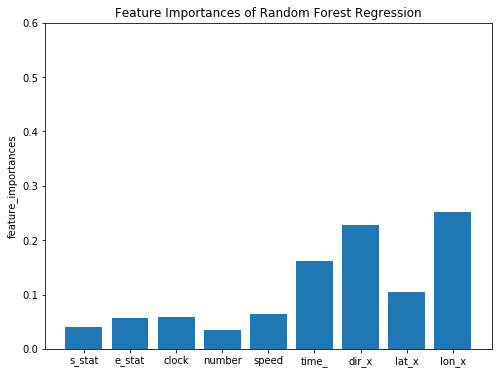

mean squared error : 6.34103978802


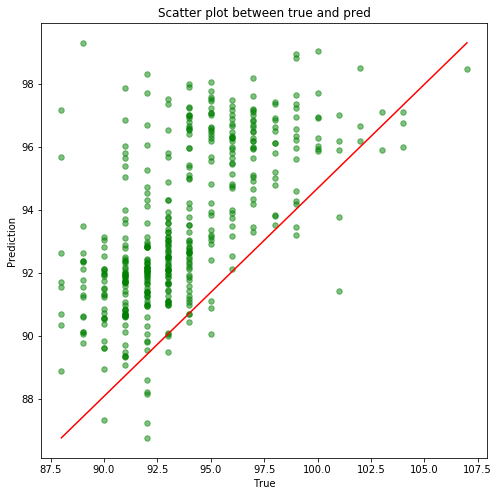

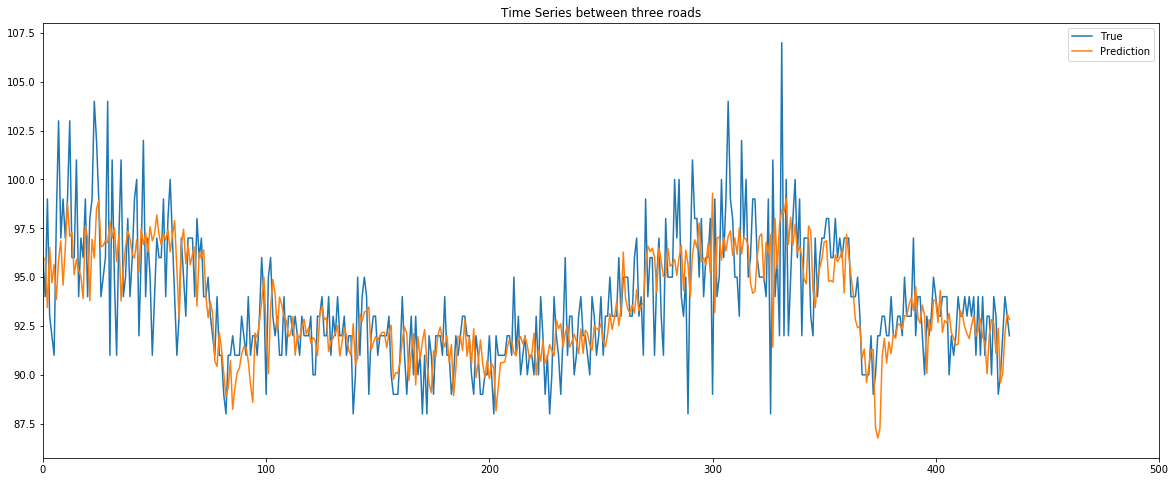

pred : [ 92.362]
true : 1042812    94
Name: speed, dtype: int64


In [35]:
dire = "S"
stat = "01F0017S"
mon = 9
day = 8
hr = 12
mins = 40

X, y, X_train, y_train, X_test, y_test, test, true = select_data(stat = stat,
                                                                 direction = dire,
                                                                 mon = mon,
                                                                 day = day,
                                                                 hr = hr,
                                                                 mins = mins)
rfr = RandomForestRegressor(n_estimators=500, max_features=6)
prediction(rfr, X, y, X_train, y_train, X_test, y_test, test, true)


In [12]:
i = list(set(g.s_stat))[6]
df[(df.s_stat == i)].head()

,s_stat,e_stat,clock,number,speed,time_
200,01F3561S,01F3590S,100,34,104,901000.0
681,01F3561S,01F3590S,96,44,109,901001.0
1162,01F3561S,01F3590S,95,31,110,901002.0
1643,01F3561S,01F3590S,98,35,107,901003.0
2124,01F3561S,01F3590S,95,43,110,901004.0


In [13]:
i = "01F3686S"
y = list(set(df[(df.s_stat == i)].e_stat))
print (y)
y2 = []
for j in y:
    y1 = np.array(df[(df.s_stat == i)&(df.e_stat == j)])
    print (y1.shape)
    y2.append(y1)
    print (np.array(y2).shape)

['03F4142N', '01F3736S', '03F4168S']
(2592, 6)
(1, 2592, 6)
(2592, 6)
(2, 2592, 6)
(2592, 6)
(3, 2592, 6)
